Install the XGBoost

In [ ]:
!pip install xgboost

In [ ]:
# Import the necessary packages
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import joblib
import nltk # for text processing
from wordcloud import WordCloud, STOPWORDS # for creating worcloud visualization
from nltk.sentiment import SentimentIntensityAnalyzer # for sentiment analysis
import matplotlib.pyplot as plt # for plotting data

plt.style.use('ggplot') # set style for matplotlib chart
plt.rcParams["font.family"] = "DejaVu Serif" # Set font family
plt.rcParams["font.serif"] = ["Times New Roman"] # Set font to Times New Roman
pd.set_option('display.max_columns',None) # set to display all the columns available

# Preprocessing

In [ ]:
# Create variable to address where the files are located
path = '/content/drive/MyDrive/Colab Notebooks/Machine Learning/Project - Smartphone/work/'

In [ ]:
# Create dataframe using Pandas
df = pd.read_excel(f'{path}null-smartphone.xlsx',sheet_name='full-smartphone')

In [ ]:
# Check if there is a duplicated data
df.duplicated().sum()

0

In [ ]:
# see the summary info of dataset including data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2552 entries, 0 to 2551
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2552 non-null   int64  
 1   brand             2552 non-null   object 
 2   products          2552 non-null   object 
 3   price             1357 non-null   object 
 4   year              2505 non-null   float64
 5   network           2462 non-null   object 
 6   connection        2462 non-null   object 
 7   dim_h             2432 non-null   float64
 8   dim_w             2435 non-null   float64
 9   dim_t             2450 non-null   float64
 10  weight            2367 non-null   float64
 11  screen            2548 non-null   float64
 12  res_x             2544 non-null   float64
 13  res_y             2543 non-null   float64
 14  screen_ratio_x    2548 non-null   object 
 15  screen_ratio_y    2548 non-null   object 
 16  pixel_density     2533 non-null   float64


In [ ]:
# see the top 3 row in the dataset
df.head(3)

,id,brand,products,price,year,network,connection,dim_h,dim_w,dim_t,weight,screen,res_x,res_y,screen_ratio_x,screen_ratio_y,pixel_density,chipset,cpu,gpu,RAM,storage,maincam,frontcam,nfc,usb,battery,battery_capacity,os
0,0,Advan,Advan XTab,1089000,2023.0,"2G, 3G, 4G",4G,211.0,124.0,9.7,351.0,8.0,800.0,1280.0,16,10,189.0,UNISOC Tiger T310,Quad-core,PowerVR GE8300,4.0,64.0,5.0,2.0,0.0,USB Type-C 2.0,Li-Po,4000.0,Android 13
1,1,Advan,Advan Tab Sketsa 3,2099000,2023.0,"2G, 3G, 4G",4G,241.6,160.4,9.6,557.0,10.1,1280.0,800.0,4,3,150.0,UNISOC Tiger T606,Octa-core,Mali-G57 MP1,6.0,128.0,8.0,5.0,0.0,USB Type-C 2.0,Li-Po,6000.0,Android 13
2,2,Advan,Advan Tab VX Lite,2000000,2023.0,"2G, 3G, 4G",4G,NaN,NaN,NaN,NaN,10.4,1200.0,2000.0,5,3,224.0,UNISOC Tiger T618,Octa-core,Mali-G52 MP2,6.0,128.0,8.0,5.0,0.0,USB Type-C 2.0,Li-Po,6000.0,Android 13


In [ ]:
# because there are mixed type in these columns need to fix it
# these columns supposed to be numeric data but there are whitespaces that need to be cleaned
df.loc[df['screen_ratio_x']=='','screen_ratio_x'] = np.nan
df.loc[df['screen_ratio_y']=='','screen_ratio_y'] = np.nan
df.loc[df['screen_ratio_x']=='  ','screen_ratio_x'] = np.nan
df.loc[df['screen_ratio_y']=='  ','screen_ratio_y'] = np.nan
df.loc[df['price']==' ','price'] = np.nan

In [ ]:
# convert the data type to be numeric either it's float or integer
df['price'] = df['price'].astype('float64')
df['screen_ratio_x'] = df['screen_ratio_x'].astype('float64')
df['screen_ratio_y'] = df['screen_ratio_y'].astype('float64')

In [ ]:
# fill the null value for year column using forward fill method
# forward fill will fill the null value using the value one row above the null value
df['year'] = df['year'].fillna(method='ffill')

In [ ]:
# convert the type to be integer
df['year'] = df['year'].astype('int64')

In [ ]:
df.columns

Index(['id', 'brand', 'products', 'price', 'year', 'network', 'connection',
       'dim_h', 'dim_w', 'dim_t', 'weight', 'screen', 'res_x', 'res_y',
       'screen_ratio_x', 'screen_ratio_y', 'pixel_density', 'chipset', 'cpu',
       'gpu', 'RAM', 'storage', 'maincam', 'frontcam', 'nfc', 'usb', 'battery',
       'battery_capacity', 'os'],
      dtype='object')

In [ ]:
# Create two variables of list which contain the name of columns which then divided into 2, categorical and numerical
cat_col = ['connection','battery','os', 'chipset', 'cpu', 'gpu', 'usb']
num_col = ['price', 'weight', 'res_x', 'res_y',\
           'screen_ratio_x', 'screen_ratio_y', 'battery_capacity', 'screen',\
           'pixel_density', 'storage', 'RAM', 'maincam',\
           'frontcam','dim_h', 'dim_w', 'dim_t']

In [ ]:
# strip the whitespaces for this column
df['chipset'] = df['chipset'].str.strip()

In [ ]:
# using the forward fill again to fill the null value
df['nfc'].fillna(method='ffill',inplace=True)

In [ ]:
# check the unique value for this column
df['connection'].unique()

array(['4G', '3G', '5G', nan, '2G'], dtype=object)

In [ ]:
# remove the '-' character
df.loc[df['os']=='-','os'] = np.nan

In [ ]:
# remove the whitespaces
df.loc[df['battery']=='','battery'] = np.nan
df.loc[df['battery']==' ','battery'] = np.nan
df.loc[df['chipset']=='','chipset'] = np.nan
df.loc[df['chipset']==' ','chipset'] = np.nan
df.loc[df['gpu']=='','gpu'] = np.nan
df.loc[df['gpu']==' ','gpu'] = np.nan
df.loc[df['cpu']=='','cpu'] = np.nan
df.loc[df['cpu']==' ','cpu'] = np.nan
df.loc[df['usb']=='','usb'] = np.nan
df.loc[df['usb']==' ','usb'] = np.nan

In [ ]:
# Create an instance for data imputation for categorical using SimpleImputer with the most frequent value is the strategy
cat_imp = SimpleImputer(strategy='most_frequent')
# For numerical value using KNNImputer which will cluster the value and then pick the closest to 4 neighbors
num_imp = KNNImputer(n_neighbors=4)

In [ ]:
# remove the duplicates from products column
df.drop_duplicates(subset=['products'],inplace=True)

In [ ]:
# Loop through the list categorical columns
for x in cat_col:
  # Start imputing using SimpleImputer
  # Because the returned value from SimpleImputer is an array we need to reshaped the value to (-1,1)
  df[x] = cat_imp.fit_transform(df[x].values.reshape(-1,1))[:,0]
# Imputing for numerical columns (KNNImputer is multivariate so it can do multiple columns to find the closest value)
df[num_col] = num_imp.fit_transform(df[num_col])

In [ ]:
# Round the decimal value
df['price'] = round(df['price'])
df['battery_capacity'] = round(df['battery_capacity'])
df['RAM'] = round(df['RAM'])
df['storage'] = round(df['storage'])
df['pixel_density'] = round(df['pixel_density'])
df['maincam'] = round(df['maincam'],1)
df['frontcam'] = round(df['frontcam'],1)
df['weight'] = round(df['weight'],1)
df['screen'] = round(df['screen'],2)

In [ ]:
# Convert float value into integer
df['price'] = df['price'].astype('int64')
df['battery_capacity'] = df['battery_capacity'].astype('int64')
df['RAM'] = df['RAM'].astype('int64')
df['storage'] = df['storage'].astype('int64')
df['pixel_density'] = df['pixel_density'].astype('int64')
df['nfc'] = df['nfc'].astype('int64')

In [ ]:
# Uncomment and run the line of code below to save it into CSV
# df.to_csv(f'{path}full-smartphone.csv',index=False)

# Create Model

In [ ]:
# Create features variable which just the name of the columns used for training the model
feature = ['brand', 'year','connection', 'weight', 'battery',\
           'battery_capacity','screen', 'pixel_density',\
           'storage', 'RAM', 'cpu', 'maincam', 'frontcam','nfc']
# create variable X which also One-hot encoding dataframe the categorical columns
X = pd.get_dummies(df[feature])
# Target variable
y = df['price']
# split the data for training and validation
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [ ]:
from sklearn.preprocessing import StandardScaler


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# define the model and fit training data into it
reg = XGBRegressor()
reg.fit(X_train_scaled,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# create prediction
prediction = reg.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [ ]:
print('rmse',np.sqrt(mean_squared_error(y_test,prediction)))
print('mape',mean_absolute_percentage_error(y_test,prediction))

rmse 2465774.0769334505
mape 0.32676791731594196


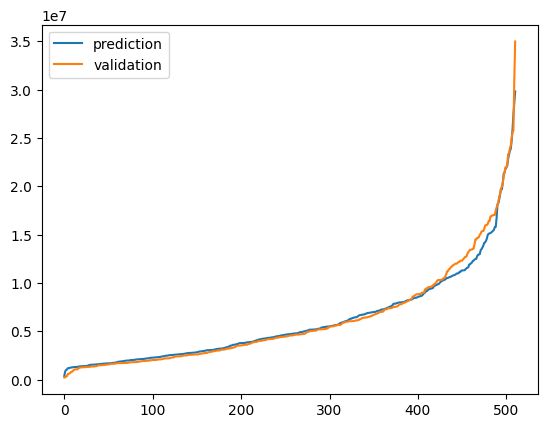

In [ ]:
# plot the result of prediction and validation
plt.plot(sorted(prediction),label='prediction')
plt.plot(sorted(y_test),label='validation')

plt.legend()

In [ ]:
# Uncomment and run line of code below to save the model
# joblib.dump(reg,f'{path}regressorModel.joblib')

['/content/drive/MyDrive/Colab Notebooks/Machine Learning/Project - Smartphone/work/regressorModel.joblib']

# Sentiment Analysis

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Machine Learning/Project - Smartphone/ScrappedRAW_Data/' # initiate the path to the working directory

In [ ]:
df = pd.read_csv(f'{path}Reviews.csv') # read the csv file from working directory
df = df.dropna().reset_index(drop=True) # drop the null values from the data

In [ ]:
nltk.download('vader_lexicon') # download the VADER package for SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer() # define the SentimentIntensityAnalyzer as sia

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
df = df.reset_index().rename(columns={'index':'id'}) # resetting index for purpose of creating unique identifier
df['id'] = df['id'].apply(lambda x: x+1) # the value start from 1 instead of 0

In [ ]:
res = {} # initiate empty dictionary for saving the value from for loop
for x in range(len(df)): # loop through the data frame
  rev = df['reviews'][x]
  id = df['id'][x]

  res[id] = sia.polarity_scores(rev) # insert value to the dictionary

In [ ]:
review = pd.DataFrame(res).T # create data frame from the dictionary
review = review.reset_index().rename(columns={'index':'id'}) # reset index to create unique identifier

# merge the two data frames it's like JOIN in SQL
df = df.merge(review,how='left') # this merge method will automatically find the similar columns between two dfs to merge on

In [ ]:
""" Create a function
    that return positive if the compound value is positive
    or if the compound value is 0 then it will return Neutral
    and if the compound value is nrgative then it will return Negative
    compound values vary from -1 to 1"""

def sentiments(c):
  if c > 0:
    return 'Positive'
  elif c == 0:
    return 'Neutral'
  else:
    return 'Negative'

In [ ]:
df['sentiment'] = df['compound'].apply(sentiments) # apply the function to the data frame's column
# df.to_csv(f'{path}sentiment_review.csv',index=False) # save data frame to csv

sentimen = df['sentiment'].value_counts().reset_index() # create a new data frame from value_counts method to create visualizaton

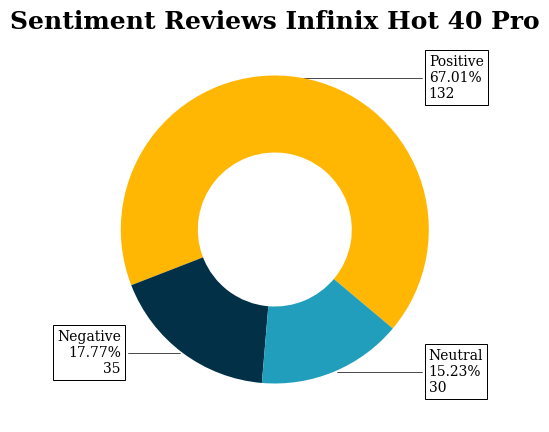

In [ ]:
labels= sentimen['sentiment']
values = sentimen['count']
pallete = ['#ffb703','#023047','#219ebc']

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal")) # define the matplotlib figure
wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), startangle=-40, colors=pallete) # create the pie

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72) # initiate bbox for annotation later
kw = dict(arrowprops=dict(arrowstyle="-",color='black'),
          bbox=bbox_props, zorder=0, va="center") # create **kwargs for connection line

for i, p in enumerate(wedges): # loop through the components of pie
    ang = (p.theta2 - p.theta1)/2. + p.theta1 # calculate the angle using theta
    y = np.sin(np.deg2rad(ang)) # calculate sin for angle in radians
    x = np.cos(np.deg2rad(ang)) # calculate cosine for angle in radians
     # horizontal alignment for annotation it doesn't have to be complicated like this it can be as simple as 'center'
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}" # define the angle for connection line
    kw["arrowprops"].update({"connectionstyle": connectionstyle}) # update the **kwargs dictionary by inserting connection line angle

    # annotation for percentage, label, and values
    # as well as the position of the annotation text
    ax.annotate(f'{labels[i]}\n{round((values[i]/sum(values))*100,2)}%\n{values[i]}', xy=(x, y), xytext=(np.sign(x), y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Sentiment Reviews Infinix Hot 40 Pro",fontweight='bold',fontsize=18,ha='center') # set the title of the chart
# plt.savefig(f'{path}/sentimentreviews.png',bbox_inches='tight') # save the chart
plt.show()

In [ ]:
reviews_word = '' # define the empty string to store all the reviews from for loop
for x in df['reviews']: # loop through all the reviews
  token = x.split()
  reviews_word += " ".join(token)+" " # store the reviews to be one big sentence

In [ ]:
pos_reviews_word = '' # define the empty string to store all the reviews from for loop
for x in df.loc[df['sentiment']=='Positive','reviews']: # loop through positive reviews
  token = x.split()
  pos_reviews_word += " ".join(token)+" " # store the reviews to be one big sentence

neg_reviews_word = '' # define the empty string to store all the reviews from for loop
for x in df.loc[df['sentiment']=='Negative','reviews']: # loop through negative reviews
  token = x.split()
  neg_reviews_word += " ".join(token)+" " # store the reviews to be one big sentence

In [ ]:
stopwords = set(STOPWORDS) # set the stopwords to remove the stopwords
# stopwords are words with less meaning in sentences like 'a','the','is' and etc.
# check here https://kavita-ganesan.com/what-are-stop-words/ to know more about stopwords

# generate wordcloud using WordCloud from wordcloud package
# all reviews
wordcloud = WordCloud(background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(reviews_word)
# positive reviews wordcloud
pos_wordcloud = WordCloud(background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(pos_reviews_word)
# negative reviews wordcloud
neg_wordcloud = WordCloud(background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(neg_reviews_word)

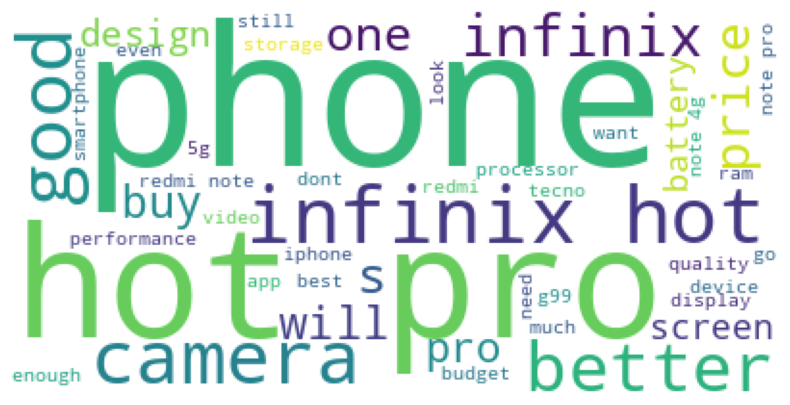

In [ ]:
# Plot the wordcloud generated earlier using matplotlib imshow
plt.figure(figsize = (8, 12), facecolor = None) # define the figure and its size
plt.imshow(wordcloud) # show the wordcloud
plt.axis("off") # turn off the axis
plt.tight_layout()
# plt.savefig(f'{path}wordcloud.png',bbox_inches='tight',dpi=300) # save the fig
plt.show()

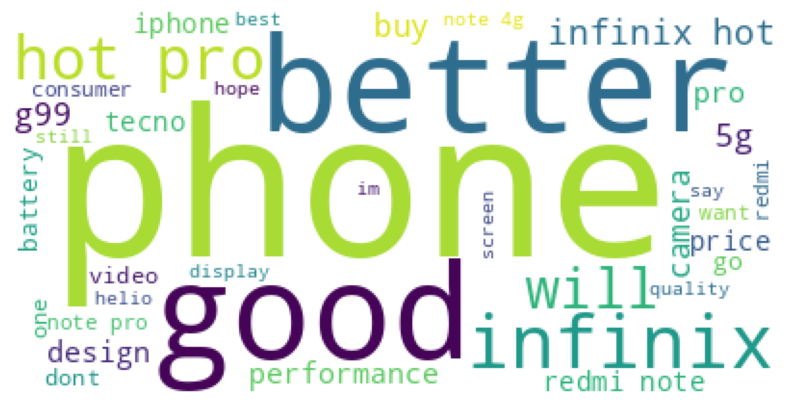

In [ ]:
# Plot the positive reviews wordcloud generated earlier using matplotlib imshow
plt.figure(figsize = (8, 12), facecolor = None) # define the figure and its size
plt.imshow(pos_wordcloud) # show the wordcloud
plt.axis("off") # turn off the axis
plt.tight_layout()
# plt.savefig(f'{path}positive_wordcloud.png',bbox_inches='tight',dpi=300) # save the fig
plt.show()

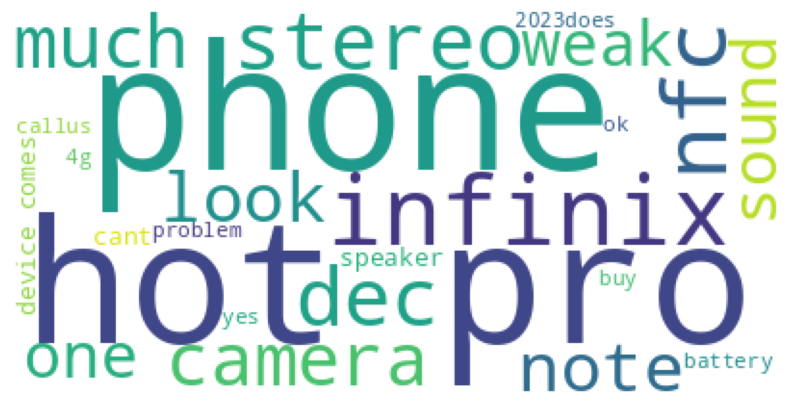

In [ ]:
# Plot the negative reviews wordcloud generated earlier using matplotlib imshow
plt.figure(figsize = (8, 12), facecolor = None) # define the figure and its size
plt.imshow(neg_wordcloud) # show the wordcloud
plt.axis("off") # turn off the axis
plt.tight_layout()
# plt.savefig(f'{path}negative_wordcloud.png',bbox_inches='tight',dpi=300) # save the fig
plt.show()